# Objective:
Predict poverty on a household level
The Target values represent poverty levels as follows:

1 = extreme poverty

2 = moderate poverty 

3 = vulnerable households

4 = non vulnerable households

## About data provided:

     Here we are provided with a modelling data of 9557 rows and 143 features which consists of various factors that effects the household poverty level in some way.
     One row of information tells about one person
     Data consists of living situation,dependency of an individual,education,age etc
     Below is the list of the features with there name and description

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
family=pd.read_csv('data1.csv')

In [4]:
family.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


# Data preprocessing

In [5]:
#checking and treating missing values
family.isnull().sum().nlargest(10)

rez_esc      7928
v18q1        7342
v2a1         6860
meaneduc        5
SQBmeaned       5
Id              0
hacdor          0
rooms           0
hacapo          0
v14a            0
dtype: int64

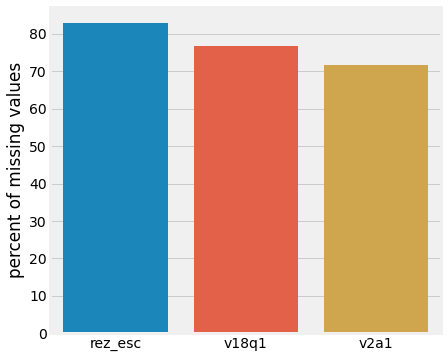

In [6]:
missing=pd.DataFrame(100*family.isnull().sum()/len(family),columns=["percent of missing values"]).sort_values(ascending=False,by
                                                                                                       ="percent of missing values")
plt.figure(figsize=(7,6))
plt.style.use("fivethirtyeight")
sns.barplot(x=missing.index[:3],y=missing["percent of missing values"][:3])
plt.show()

Well as we can observe here the missing values in these features is very high almost between 70% to 80% of the data, hence we drop these columns.

And other features have very less values, hence we will impute them with mean values

In [7]:
family.drop(columns=['rez_esc','v18q1','v2a1','Id'],inplace=True)

In [8]:
family.isnull().sum().nlargest(10)

meaneduc     5
SQBmeaned    5
hacdor       0
rooms        0
hacapo       0
v14a         0
refrig       0
v18q         0
r4h1         0
r4h2         0
dtype: int64

In [9]:
family.replace(np.nan,family.mean(),inplace=True)

In [10]:
family.isnull().sum().nlargest(10)

hacdor    0
rooms     0
hacapo    0
v14a      0
refrig    0
v18q      0
r4h1      0
r4h2      0
r4h3      0
r4m1      0
dtype: int64

In [11]:
family.select_dtypes(include=object)

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no
...,...,...,...,...
9552,d6c086aa3,.25,9,no
9553,d6c086aa3,.25,9,no
9554,d6c086aa3,.25,9,no
9555,d6c086aa3,.25,9,no


In [12]:
family.replace(to_replace={'yes':1,'no':0},inplace=True)

In [13]:
family.dependency=family.dependency.astype('float')
family.edjefe=family.edjefe.astype('int')
family.edjefa=family.edjefa.astype('int')

In [14]:
family.select_dtypes(include=object)

,idhogar
0,21eb7fcc1
1,0e5d7a658
2,2c7317ea8
3,2b58d945f
4,2b58d945f
...,...
9552,d6c086aa3
9553,d6c086aa3
9554,d6c086aa3
9555,d6c086aa3


In [51]:
#idoghar column here is an unique identifier for an household, which says that there is data of 2988 families
#hence we keep idoghar column for visualization but can be dropped for model building

print('No of families in Extreme poverty are:',len(family[family['Target']==1].groupby('idhogar')))
print('No of families in Moderate poverty are:',len(family[family['Target']==2].groupby('idhogar')))
print('No of families in Vulnerable household are:',len(family[family['Target']==3].groupby('idhogar')))
print('No of families in Non-Vulnerable poverty are:',len(family[family['Target']==4].groupby('idhogar')))

No of families in Extreme poverty are: 242
No of families in Moderate poverty are: 487
No of families in Vulnerable household are: 387
No of families in Non-Vulnerable poverty are: 1958


In [69]:
len(family['idhogar'].unique())

2988

Here the families count comes to 3074, but when checked by idhogar we have 2988 families, which tells us a different story.

As the data is with respect to individuals lets dig deep and look if any two individuals from same family or idhogar fall into different household level target.

In [54]:
#Z is a table formed with idhogar and target types.
z=pd.crosstab(index=family.idhogar,columns=family.Target)

In [55]:
#values under 1 to 4 here represents, individuals in that particular family falling into a specific target value. 
z.head()

Target,1,2,3,4
idhogar,,,,
001ff74ca,0,0,0,2
003123ec2,0,4,0,0
004616164,0,2,0,0
004983866,0,0,2,0
005905417,0,3,0,0


In [56]:
#Any family which has greated than has different individuals in different target values will be identified and stored in dup

dup=z[((z[1]>0)& (z[2]>0)) | ((z[1]>0)& (z[3]>0)) | ((z[1]>0)& (z[4]>0)) | ((z[2]>0)& (z[3]>0)) | ((z[2]>0)& (z[4]>0)) | 
      ((z[3]>0)& (z[4]>0)) ].index.tolist()

In [58]:
len(dup)

85

There are 85 idhogar ids appear in diff target which makes few individuals in different class than there family household status.

This tells us that out of 2988 families, there are 85 such families which have individuals assigned to different target class.

SO lets consider the target assigned to head of the family as the family's target class.

lets check with respect to parentecso1 as it siginfies the head of the family which gives the no of familes with heads

In [70]:
len(family[family['parentesco1']==1][['idhogar']])

2973

Hence, we have 2973 families with head of the household and 15 families with no head of the household.

In [71]:
#Count of families in different classes(families with head of the households).

print('No of families in Extreme poverty are:',len(family[(family['parentesco1']==1)&(family['Target']==1)].groupby('idhogar')))
print('No of families in Moderate poverty are:',len(family[(family['parentesco1']==1)&(family['Target']==2)].groupby('idhogar')))
print('No of families in Vulnerable household are:',len(family[(family['parentesco1']==1)&(family['Target']==3)].groupby('idhogar')))
print('No of families in Non-Vulnerable poverty are:',len(family[(family['parentesco1']==1)&(family['Target']==4)].groupby('idhogar')))

No of families in Extreme poverty are: 222
No of families in Moderate poverty are: 442
No of families in Vulnerable household are: 355
No of families in Non-Vulnerable poverty are: 1954


In [84]:
#lets find out the target class of families with no heads of the household
heads=family[family['parentesco1']==1]['idhogar'].tolist()

In [96]:
mask=family['idhogar'].isin(heads)
noheads=family[~mask]['idhogar'].unique().tolist()

In [102]:
#list of idhogar ids which dont have a head of the household
noheads

['09b195e7a',
 '896fe6d3e',
 '61c10e099',
 '374ca5a19',
 'bfd5067c2',
 '1367ab31d',
 '6b1b2405f',
 'f2bfa75c4',
 '03c6bdf85',
 'ad687ad89',
 'b1f4d89d7',
 'c0c8a5013',
 'a0812ef17',
 'd363d9183',
 '1bc617b23']

In [103]:
no_heads_family=family[~mask]

In [110]:
no_heads_family.groupby('Target')['idhogar'].value_counts()

Target  idhogar  
3       c0c8a5013    3
        f2bfa75c4    3
        03c6bdf85    2
        bfd5067c2    2
        09b195e7a    1
        1367ab31d    1
        1bc617b23    1
        374ca5a19    1
        61c10e099    1
        896fe6d3e    1
        a0812ef17    1
        ad687ad89    1
        b1f4d89d7    1
        d363d9183    1
4       6b1b2405f    3
Name: idhogar, dtype: int64

In [112]:
#Count of families in different classes(families with no head of the households).

print('No of families in Extreme poverty are:',len(no_heads_family[no_heads_family['Target']==1].groupby('idhogar')))
print('No of families in Moderate poverty are:',len(no_heads_family[no_heads_family['Target']==2].groupby('idhogar')))
print('No of families in Vulnerable household are:',len(no_heads_family[no_heads_family['Target']==3].groupby('idhogar')))
print('No of families in Non-Vulnerable poverty are:',len(no_heads_family[no_heads_family['Target']==4].groupby('idhogar')))

No of families in Extreme poverty are: 0
No of families in Moderate poverty are: 0
No of families in Vulnerable household are: 14
No of families in Non-Vulnerable poverty are: 1


14 families fall in vulnerable household and 1 familiy falls under non-vulnerable household class. This is due to most of the families or idhogar ids have only one person under them.

# Visualization

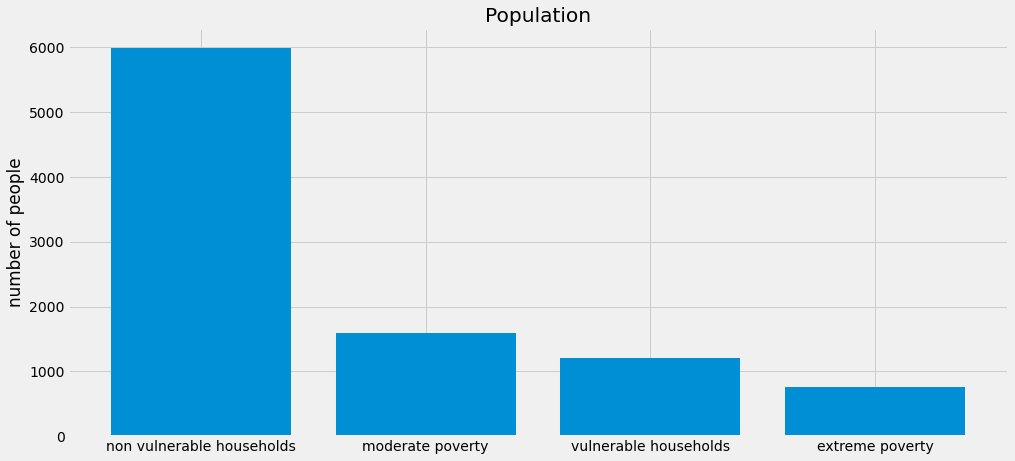

In [15]:
Target=family.Target.value_counts()
x1=['non vulnerable households','moderate poverty','vulnerable households','extreme poverty']
plt.figure(figsize=(15,7))
plt.bar(x=x1,height=Target)
plt.title('Population')
plt.ylabel('number of people')
plt.show()

In [16]:
family.Target.value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

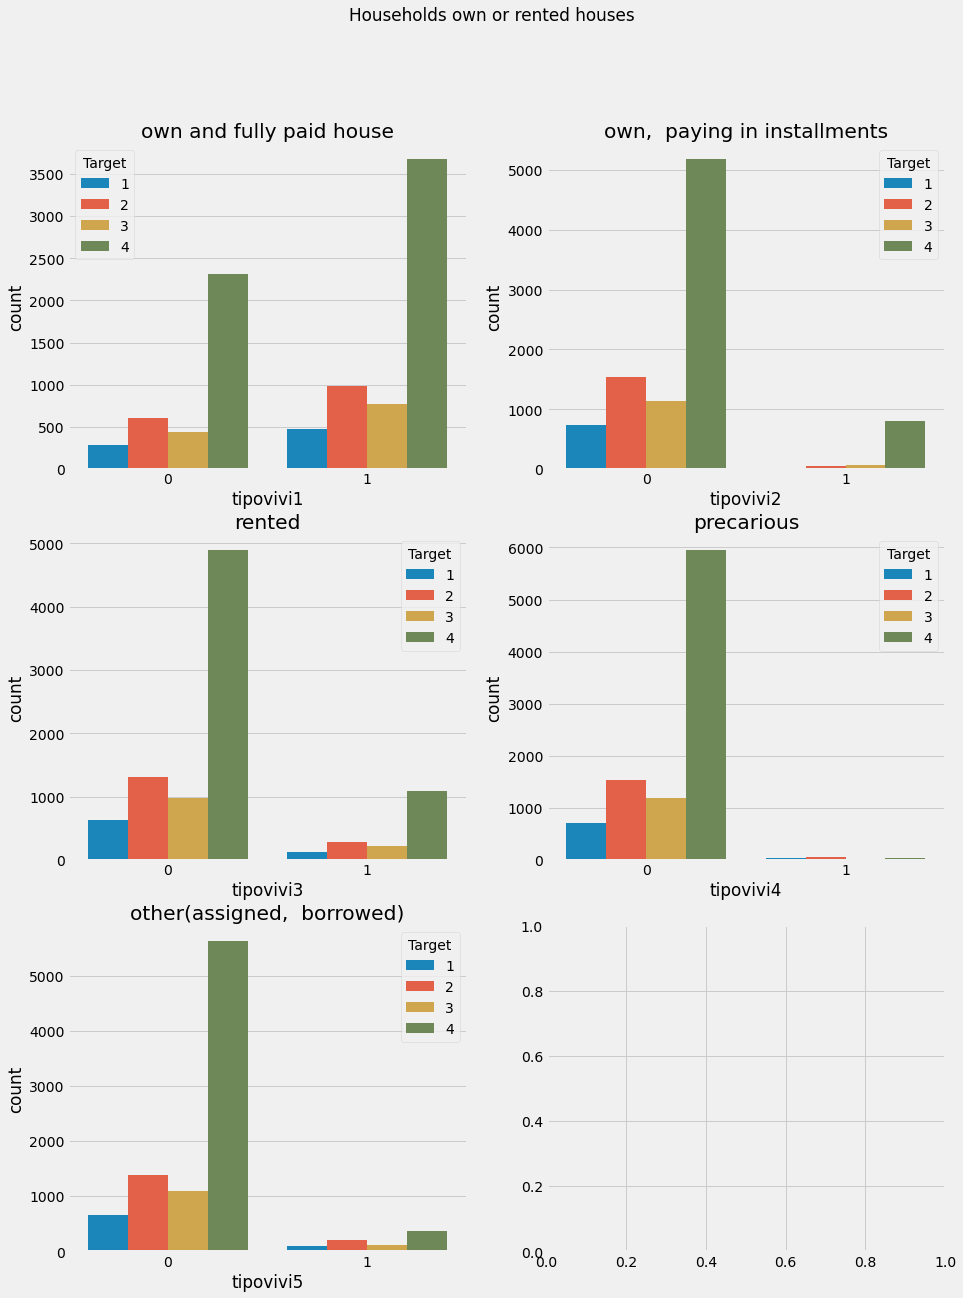

In [17]:
a,b=plt.subplots(3,2,figsize=(14,19))
sns.countplot(family['tipovivi1'],hue=family['Target'],ax=b[0,0])
b[0,0].set_title('own and fully paid house')


sns.countplot(family['tipovivi2'],hue=family['Target'],ax=b[0,1])
b[0,1].set_title('own,  paying in installments')


sns.countplot(family['tipovivi3'],hue=family['Target'],ax=b[1,0])
b[1,0].set_title('rented')


sns.countplot(family['tipovivi4'],hue=family['Target'],ax=b[1,1])
b[1,1].set_title('precarious')


sns.countplot(family['tipovivi5'],hue=family['Target'],ax=b[2,0])
b[2,0].set_title('other(assigned,  borrowed)')

plt.suptitle('Households own or rented houses')
plt.show()

### What do they own?

In [18]:
level=family.groupby('Target')[['refrig','v18q','television','mobilephone']].agg('sum')
level=level.div(Target,axis="rows")*100
level

,refrig,v18q,television,mobilephone
1,88.741722,7.947020,11.920530,94.304636
2,92.861616,7.827176,20.100188,95.554164
3,96.195203,11.827957,24.979322,95.616212
4,97.331554,31.470981,33.472315,98.849233


<Figure size 1080x504 with 0 Axes>

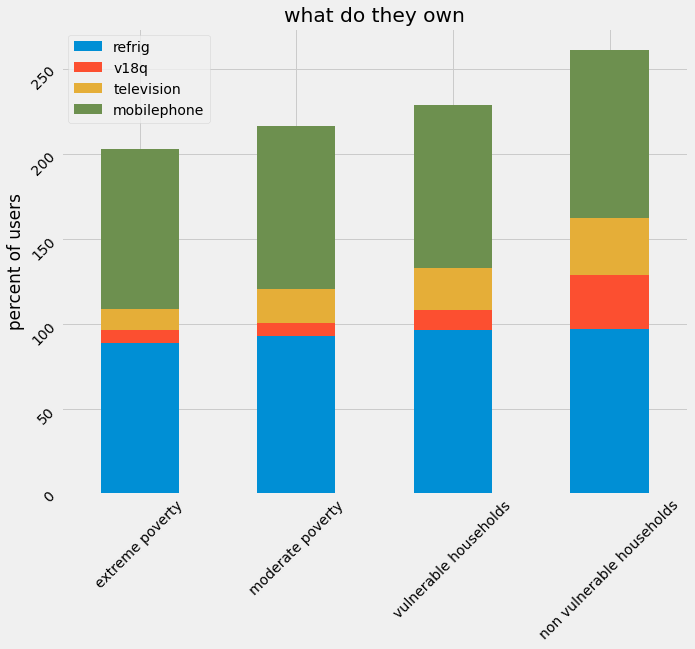

In [19]:
plt.figure(figsize=(15,7))
level.plot(kind='bar',stacked=True,figsize=(10,8))
plt.title('what do they own')
plt.ylabel('percent of users')
plt.xticks(ticks=[0,1,2,3],labels=['extreme poverty','moderate poverty','vulnerable households','non vulnerable households'])
plt.tick_params(rotation=45)
plt.show()

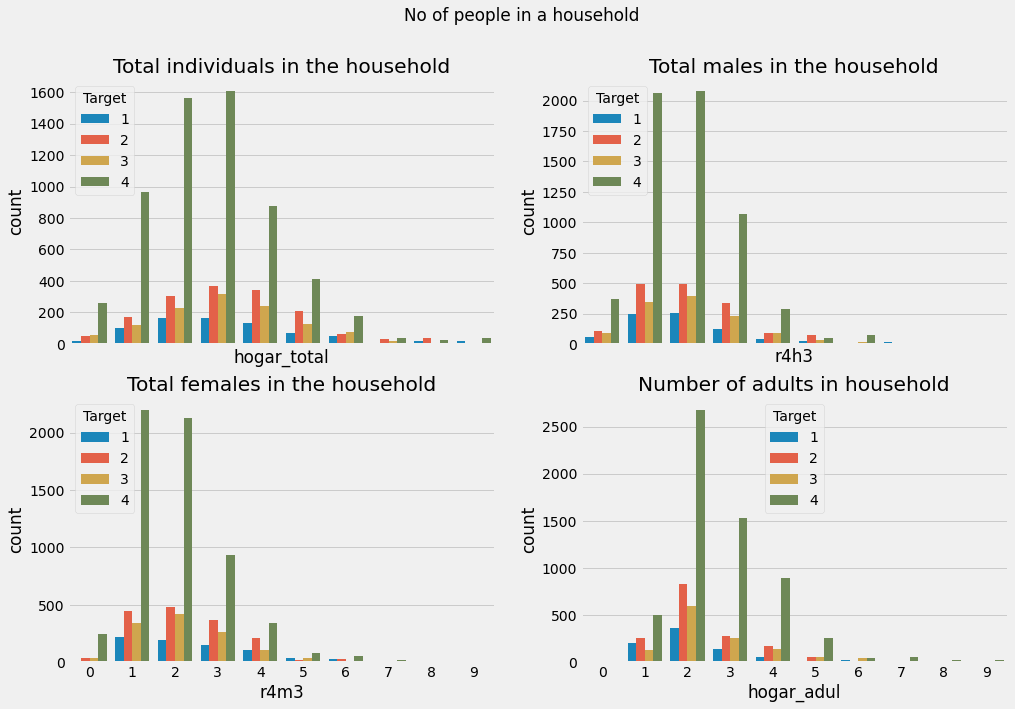

In [20]:
fig,axes=plt.subplots(2,2,figsize=(15,10),sharex=True)
sns.countplot(x=family['hogar_total'],hue=family['Target'],ax=axes[0,0])
axes[0,0].set_title('Total individuals in the household')

sns.countplot(x=family['r4h3'],hue=family['Target'],ax=axes[0,1])
axes[0,1].set_title('Total males in the household')

sns.countplot(x=family['r4m3'],hue=family['Target'],ax=axes[1,0])
axes[1,0].set_title('Total females in the household')

sns.countplot(x=family['hogar_adul'],hue=family['Target'],ax=axes[1,1])
axes[1,1].set_title('Number of adults in household')

plt.suptitle("No of people in a household")
plt.show()

In [21]:
family.groupby('Target')[['hogar_total','r4h3','r4m3','hogar_adul']].agg("mean")

,hogar_total,r4h3,r4m3,hogar_adul
Target,,,,
1,4.455629,1.956291,2.501987,2.147020
2,4.361929,2.035066,2.335629,2.341265
3,4.272953,2.097601,2.182796,2.600496
4,3.789693,1.888926,1.907605,2.713809


### water provision

In [22]:
elec=family[family['abastaguano']==0].groupby("Target")[['abastaguadentro','abastaguafuera']].agg('sum')
elec=elec.div(Target,axis="rows")*100
elec

,abastaguadentro,abastaguafuera
1,95.629139,3.973510
2,93.675642,4.884158
3,95.368073,4.218362
4,97.548366,2.401601


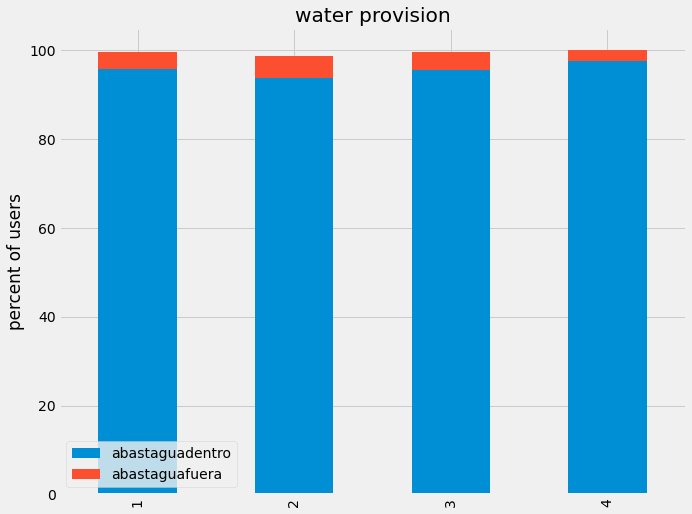

In [23]:
elec.plot(kind='bar',stacked=True,figsize=(10,8))
plt.title('water provision')
plt.ylabel('percent of users')
plt.show()

In [24]:
family.groupby('Target')['abastaguano'].value_counts()

Target  abastaguano
1       0               752
        1                 3
2       0              1574
        1                23
3       0              1204
        1                 5
4       0              5993
        1                 3
Name: abastaguano, dtype: int64

### How are their bathrooms?

In [25]:
bathroom=family.groupby("Target")['v14a'].agg("sum").div(Target,axis="rows")*100
bathroom

1    98.807947
2    98.685034
3    99.172870
4    99.833222
dtype: float64

In [26]:
toilet=family.groupby('Target')[['sanitario1','sanitario2','sanitario3','sanitario6','sanitario5']].agg(sum)
toilet=toilet.div(Target,axis='rows')*100
toilet

,sanitario1,sanitario2,sanitario3,sanitario6,sanitario5
1,0.927152,16.026490,78.278146,0.132450,4.635762
2,0.751409,17.407639,78.271760,0.626174,2.943018
3,0.744417,12.985939,83.705542,0.000000,2.564103
4,0.150100,24.833222,74.232822,0.216811,0.567045


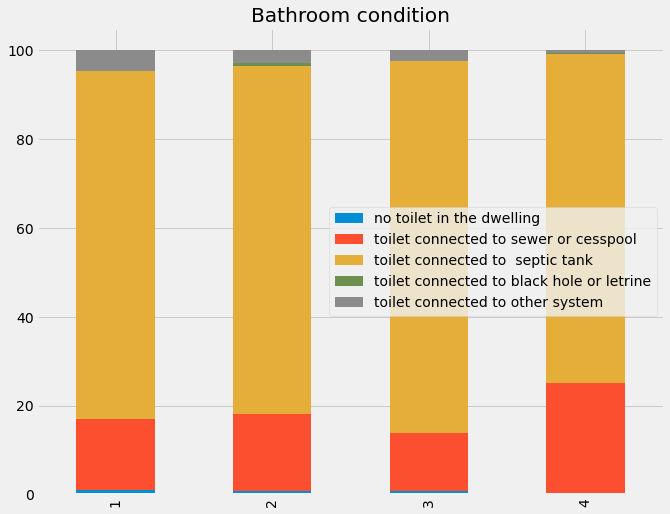

In [27]:

toilet.plot(kind='bar',stacked=True,figsize=(10,8))
plt.title('Bathroom condition')
plt.legend(['no toilet in the dwelling',
'toilet connected to sewer or cesspool',
'toilet connected to  septic tank',
'toilet connected to black hole or letrine'
,'toilet connected to other system'])
plt.show()

### How do they cook?

In [28]:
energy=family.groupby("Target")[["energcocinar1","energcocinar2","energcocinar3","energcocinar4"]].agg("sum")
energy=energy.div(Target,axis="rows")*100
energy

,energcocinar1,energcocinar2,energcocinar3,energcocinar4
1,0.927152,32.582781,53.509934,12.980132
2,0.187852,39.010645,51.346274,9.455229
3,0.248139,43.507031,49.627792,6.617039
4,0.083389,54.769847,42.645097,2.501668


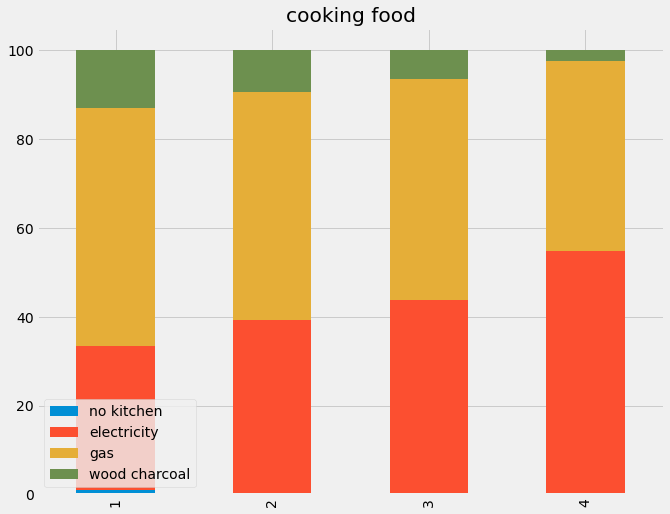

In [29]:
energy.plot(kind='bar',stacked=True,figsize=(10,8))
plt.title('cooking food')
plt.legend(['no kitchen',
'electricity',
'gas',
'wood charcoal'])
plt.show()

### What are the conditions of their houses?

In [30]:
house=family.groupby('Target')[['tipovivi1','tipovivi2','tipovivi3']].agg("sum")
house=house.div(Target,axis="rows")*100

#walls
walls=family.groupby('Target')[['epared1','epared2','epared3']].agg("sum").div(Target,axis="rows")*100

#roofs
roofs=family.groupby("Target")[['etecho1','etecho2',"etecho3"]].agg("sum").div(Target,axis="rows")*100

#floor
floor=family.groupby("Target")[['eviv1','eviv2','eviv3']].agg("sum").div(Target,axis="rows")*100

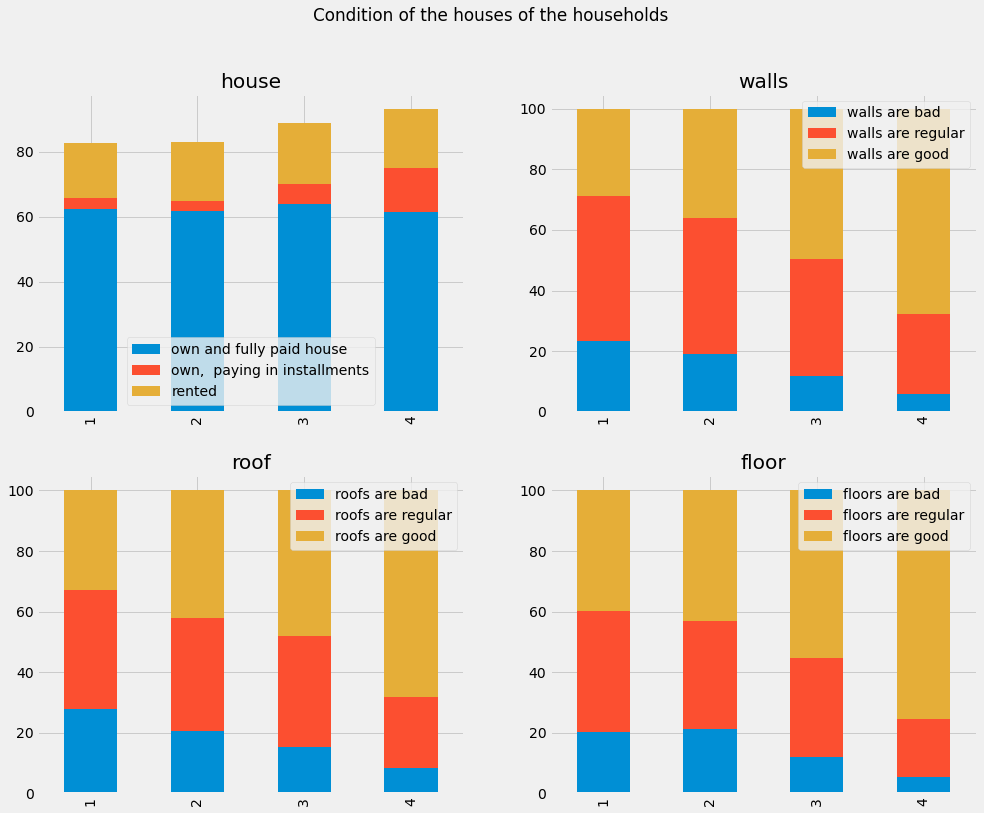

In [31]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
house.plot(kind='bar',stacked=True,ax=axes[0][0])
walls.plot(kind='bar',stacked=True,ax=axes[0][1])
roofs.plot(kind='bar',stacked=True,ax=axes[1][0])
floor.plot(kind='bar',stacked=True,ax=axes[1][1])

axes[0][0].set_title('house')
axes[0][0].legend(['own and fully paid house',
"own,  paying in installments",
'rented'])

axes[0][1].set_title('walls')
axes[0][1].legend(['walls are bad','walls are regular','walls are good'])

axes[1][0].set_title('roof')
axes[1][0].legend(['roofs are bad','roofs are regular','roofs are good'])

axes[1][1].set_title('floor')
axes[1][1].legend(['floors are bad','floors are regular','floors are good'])

plt.suptitle("Condition of the houses of the households")

plt.show()

### Where is more poverty ? urban or rural

In [32]:
pie=family.groupby('Target')[['area1',"area2"]].agg('sum').div(Target,axis="rows")*100
pie

,area1,area2
1,66.225166,33.774834
2,65.873513,34.126487
3,64.598842,35.401158
4,74.983322,25.016678


In [33]:
family[['area1',"area2"]].agg('sum').div(family.shape[0])

area1    0.714555
area2    0.285445
dtype: float64

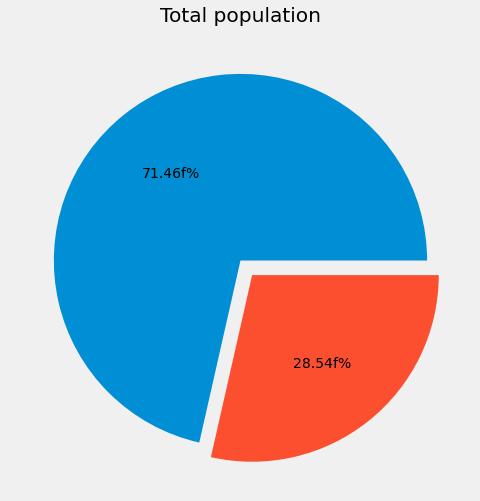

In [34]:
plt.figure(figsize=(10,8))
plt.pie(family[['area1',"area2"]].agg('sum').div(family.shape[0]),explode=[0,0.1],autopct='%1.2ff%%')
plt.title("Total population")
plt.show()

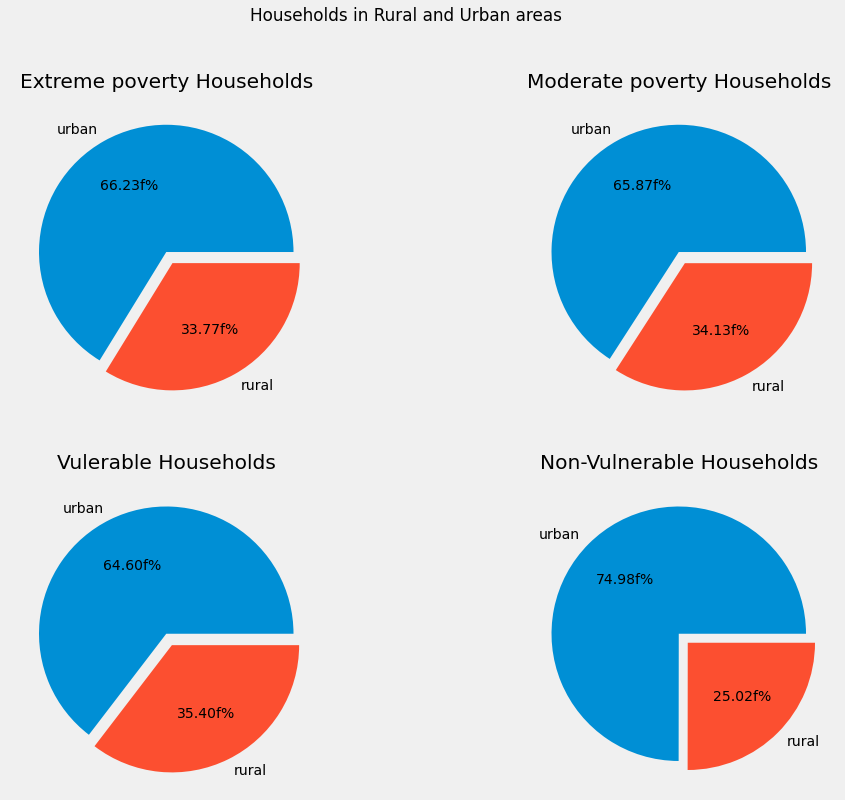

In [35]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
axes[0,0].pie(pie.values[0],labels=['urban','rural'],explode=[0,0.1],autopct='%1.2ff%%')
axes[0,0].set_title("Extreme poverty Households")

axes[0,1].pie(pie.values[1],labels=['urban','rural'],explode=[0,0.1],autopct='%1.2ff%%')
axes[0,1].set_title("Moderate poverty Households")

axes[1,0].pie(pie.values[2],labels=['urban','rural'],explode=[0,0.1],autopct='%1.2ff%%')
axes[1,0].set_title("Vulerable Households")

axes[1,1].pie(pie.values[3],labels=['urban','rural'],explode=[0,0.1],autopct='%1.2ff%%')
axes[1,1].set_title("Non-Vulnerable Households")

plt.suptitle('Households in Rural and Urban areas')
plt.show()

### Education levels

In [36]:
education=family.groupby('Target')[['instlevel1','instlevel2','instlevel3',
                                   'instlevel4','instlevel5','instlevel6',
                                  'instlevel7','instlevel8','instlevel9']].agg('sum').div(Target,axis="rows")*100
education

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
1,24.503311,27.682119,18.543046,16.688742,7.284768,1.589404,1.192053,2.516556,0.000000
2,19.724483,25.923607,23.356293,17.720726,7.576706,1.878522,0.626174,3.130870,0.062617
3,16.542597,21.505376,25.227461,19.602978,8.767577,2.564103,0.827130,4.797353,0.082713
4,9.789860,12.458306,19.462975,18.779186,13.258839,1.634423,2.001334,20.163442,2.418279


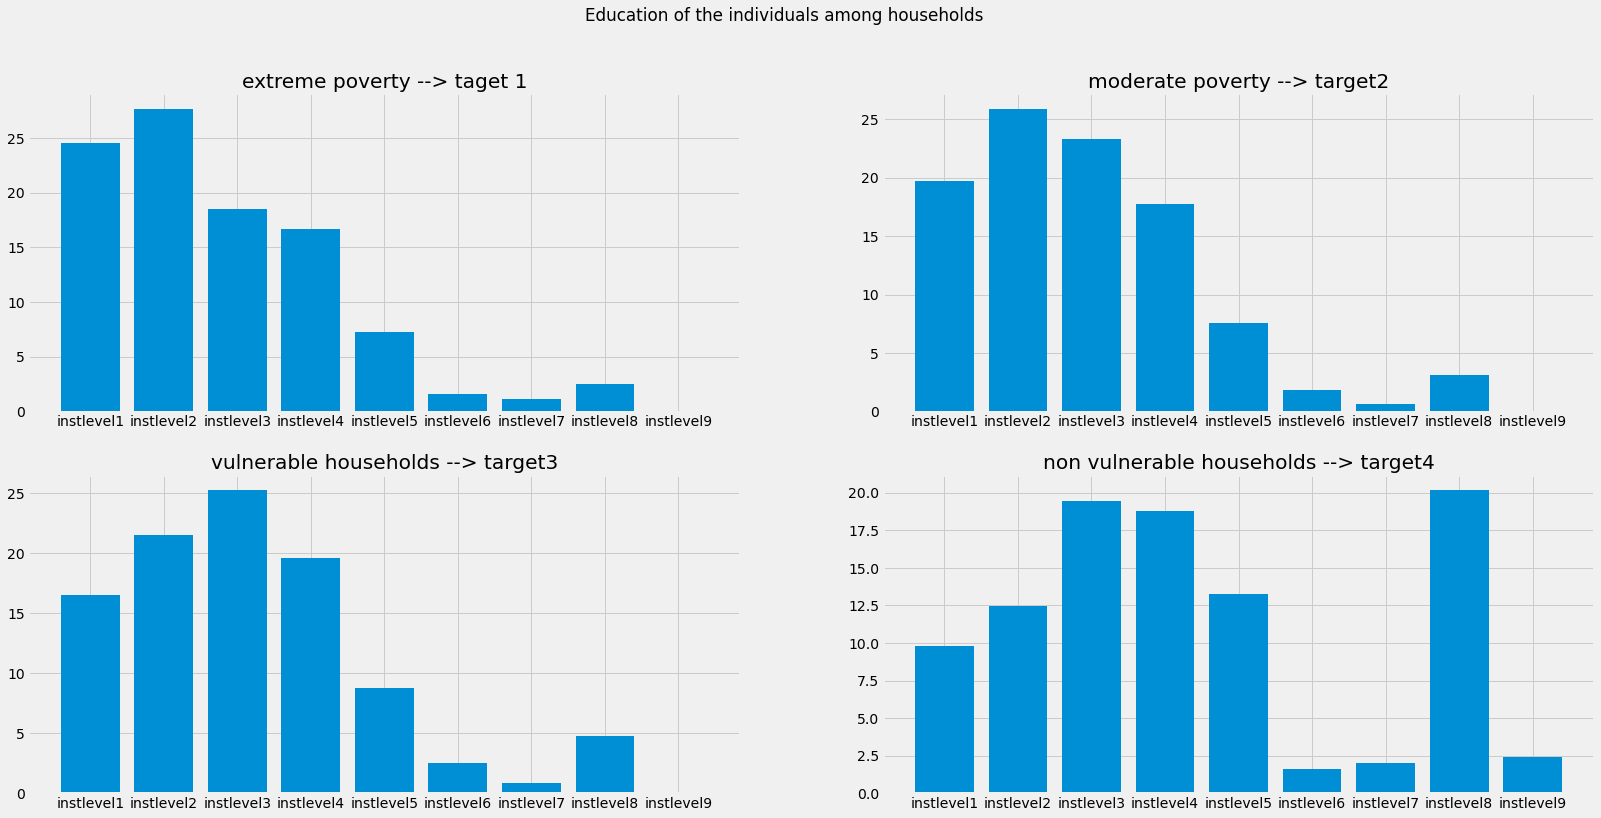

In [37]:
fig,axes = plt.subplots(2,2,figsize=(25,12))
axes[0,0].bar(education.columns,education.values[0])
axes[0,1].bar(education.columns,education.values[1])
axes[1,0].bar(education.columns,education.values[2])
axes[1,1].bar(education.columns,education.values[3])

axes[0,0].set_title('extreme poverty --> taget 1')
axes[0,1].set_title('moderate poverty --> target2')
axes[1,0].set_title('vulnerable households --> target3')
axes[1,1].set_title('non vulnerable households --> target4')

plt.suptitle('Education of the individuals among households')

plt.show()

In [38]:
family[family['parentesco1']==1]['idhogar'].value_counts()

f4b234abf    1
9a3f3aeaa    1
390dafa00    1
7ec122814    1
29b41bea5    1
            ..
7ad269eef    1
dc6ff5bb5    1
ac5482af3    1
796b14867    1
bb29fb923    1
Name: idhogar, Length: 2973, dtype: int64

There are a total of 2973 families in the population data given

In [39]:
print("There are",len(family['idhogar'].value_counts())-len(family[family['parentesco1']==1]['idhogar'].value_counts()),"families with no head of the household")

There are 15 families with no head of the household


In [40]:
Extreme=len(family[(family['parentesco1']==1)&(family['Target']==1)].groupby('Target')['idhogar'].value_counts())
Moderate=len(family[(family['parentesco1']==1)&(family['Target']==2)].groupby('Target')['idhogar'].value_counts())
Vulnerable=len(family[(family['parentesco1']==1)&(family['Target']==3)].groupby('Target')['idhogar'].value_counts())
Non_Vulnerable=len(family[(family['parentesco1']==1)&(family['Target']==4)].groupby('Target')['idhogar'].value_counts())

print("There are a total of",Extreme,"Families in the Extreme Poverty household with head of the household")
print("There are a total of",Moderate,"Families in the Moderate Poverty household with head of the household")
print("There are a total of",Vulnerable,"Families in the Vulnerable household with head of the household")
print("There are a total of",Non_Vulnerable,"Families in the Non-Vulnerable household with head of the household")

There are a total of 222 Families in the Extreme Poverty household with head of the household
There are a total of 442 Families in the Moderate Poverty household with head of the household
There are a total of 355 Families in the Vulnerable household with head of the household
There are a total of 1954 Families in the Non-Vulnerable household with head of the household


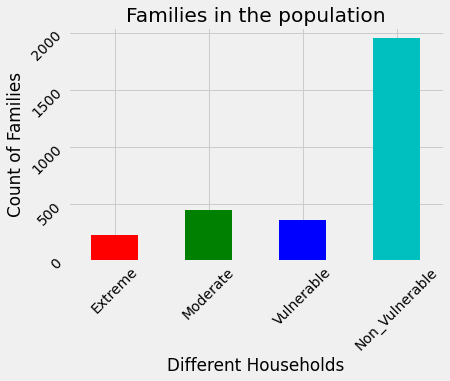

In [41]:
Families=pd.Series([Extreme,Moderate,Vulnerable,Non_Vulnerable],index=['Extreme','Moderate','Vulnerable','Non_Vulnerable'])
Families.plot(kind='bar',color=['r','g','b','c'])
plt.tick_params(rotation=45)
plt.title('Families in the population')
plt.xlabel('Different Households')
plt.ylabel('Count of Families')
plt.show()

In [42]:
list1=family['idhogar'].value_counts().index.to_list()
all_families=set(list1)

In [43]:
list2=family[family['parentesco1']==1]['idhogar'].value_counts().index.to_list()
no_head=set(list2)

In [44]:
len(all_families.difference(no_head))

15

In [45]:
N_H=all_families.difference(no_head)

In [46]:
no_head_fam=family[family['idhogar'].apply(lambda x:x in list(N_H))]

In [47]:
no_head_fam.groupby('Target')['idhogar'].value_counts()

Target  idhogar  
3       c0c8a5013    3
        f2bfa75c4    3
        03c6bdf85    2
        bfd5067c2    2
        09b195e7a    1
        1367ab31d    1
        1bc617b23    1
        374ca5a19    1
        61c10e099    1
        896fe6d3e    1
        a0812ef17    1
        ad687ad89    1
        b1f4d89d7    1
        d363d9183    1
4       6b1b2405f    3
Name: idhogar, dtype: int64

14 of 15 families from which have no head of the household belong to Vulnerable household class and one family belongs to Non-Vulnerable household

# Inferences from EDA

In [115]:
#family.to_excel('costa_rican_modelling.xlsx')